In [2]:
# Import semua library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# **Langkah 1: Membuat Dummy Data untuk Klasifikasi**
# Membuat dataset dummy dengan 2 kelas
# Komentar: Dataset ini dibuat untuk simulasi tugas klasifikasi
X, y = make_classification(n_samples=1000, n_features=10, n_informative=8, n_redundant=2, n_classes=2, random_state=42)
df = pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(X.shape[1])])
df['Target'] = y

Dataset Dummy:
    Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  -0.224515  -0.648598   2.805591   0.569525   2.676771   0.685312   
1   1.038548  -1.316803   2.303387   1.233593   4.972675   1.086905   
2   1.148988   1.794382   2.835693  -1.114858  -1.247120  -1.899268   
3  -1.177318   2.420294  -0.363514  -1.086646  -2.824750  -2.722123   
4   1.346717   0.089373   2.056613  -0.428365   0.285387   1.140716   

   Feature_7  Feature_8  Feature_9  Feature_10  Target  
0   0.306675   1.147291  -2.145905    2.477879       1  
1  -3.548788   0.342810  -0.469005    2.787109       1  
2  -0.381470   0.837209   0.163223   -0.997959       1  
3  -0.225266   0.515079  -3.317272   -2.801517       1  
4   0.721945   1.110152   2.426608    0.880496       0  
Statistik Deskriptif:
          Feature_1    Feature_2    Feature_3    Feature_4    Feature_5  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -0.077343     1.115814    -0.020803

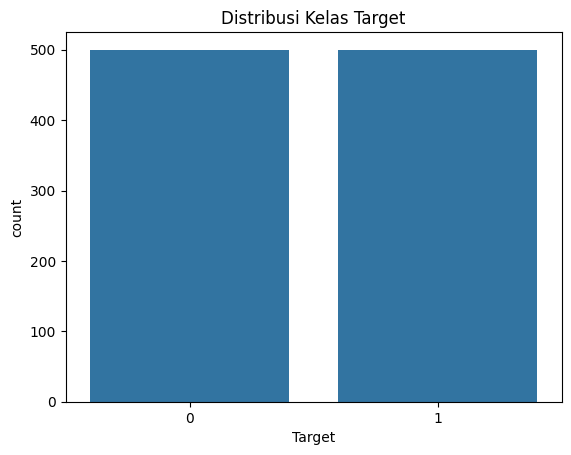

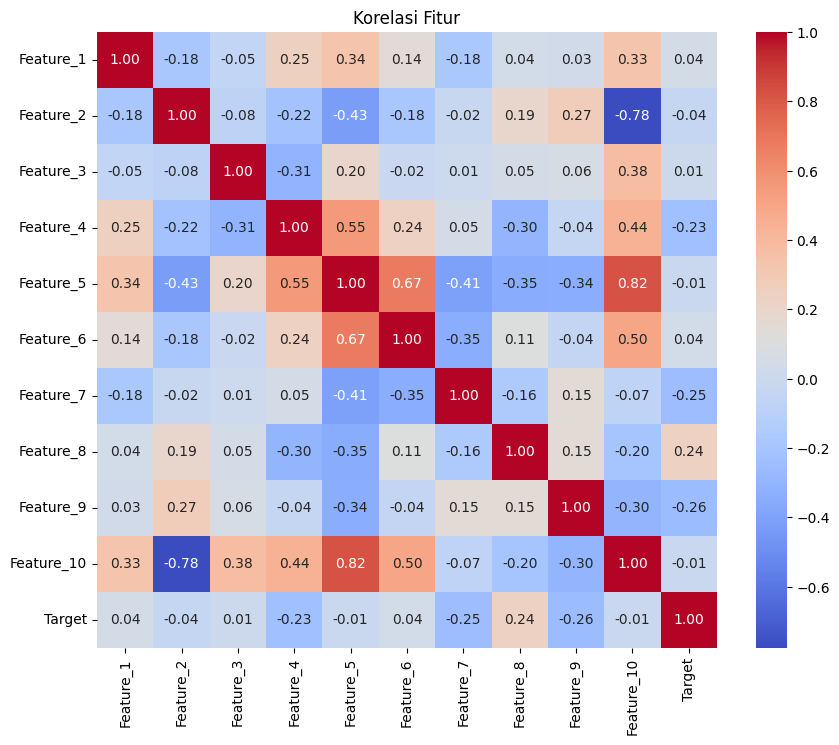

In [4]:
# **Langkah 2: Exploratory Data Analysis (EDA)**
# Menampilkan beberapa baris pertama data
print("Dataset Dummy:\n", df.head())

# Statistik dasar dari data
print("Statistik Deskriptif:\n", df.describe())

# Grafik distribusi target
sns.countplot(x='Target', data=df)
plt.title('Distribusi Kelas Target')
plt.show()

# Heatmap korelasi antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Korelasi Fitur')
plt.show()

In [5]:
# **Langkah 3: Membagi Data menjadi Train dan Test Set**
# Komentar: Data dipecah menjadi data latih dan uji untuk evaluasi model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standarisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Konversi data menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [6]:
# **Langkah 4: Membuat Model MLP dengan Variasi Parameter**
def create_mlp_model(input_dim, hidden_layers, activation_fn):
    layers = []
    for neurons in hidden_layers:
        layers.append(nn.Linear(input_dim, neurons))
        layers.append(activation_fn)
        input_dim = neurons
    layers.append(nn.Linear(input_dim, 2))  # Output layer untuk 2 kelas
    return nn.Sequential(*layers)

# Parameter yang akan dibandingkan
hidden_layer_configs = [[4], [8, 4], [16, 8, 4]]  # Variasi hidden layers
activation_functions = {
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "Linear": nn.Identity(),
    "Softmax": nn.Softmax(dim=1)
}
epochs_options = [10, 25, 50]
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [16, 32, 64]

# Variabel untuk menyimpan hasil terbaik
best_accuracy = 0
best_config = None

In [7]:
# **Langkah 5: Melakukan Training dan Evaluasi**
for hidden_layers in hidden_layer_configs:
    for activation_name, activation_fn in activation_functions.items():
        for epochs in epochs_options:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Membuat model
                    model = create_mlp_model(X_train_tensor.shape[1], hidden_layers, activation_fn)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Membuat DataLoader
                    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                    # Training
                    model.train()
                    for epoch in range(epochs):
                        for batch_X, batch_y in train_loader:
                            optimizer.zero_grad()
                            outputs = model(batch_X)
                            loss = criterion(outputs, batch_y)
                            loss.backward()
                            optimizer.step()

                    # Evaluasi
                    model.eval()
                    with torch.no_grad():
                        y_pred = model(X_test_tensor)
                        y_pred_classes = torch.argmax(y_pred, axis=1)
                        acc = accuracy_score(y_test, y_pred_classes.numpy())

                    # Menyimpan hasil terbaik
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_config = {
                            "hidden_layers": hidden_layers,
                            "activation": activation_name,
                            "epochs": epochs,
                            "learning_rate": lr,
                            "batch_size": batch_size
                        }

                    print(f"Config: HL={hidden_layers}, Act={activation_name}, Ep={epochs}, LR={lr}, BS={batch_size}, Acc={acc:.4f}")




Config: HL=[4], Act=ReLU, Ep=10, LR=0.1, BS=16, Acc=0.8850
Config: HL=[4], Act=ReLU, Ep=10, LR=0.1, BS=32, Acc=0.8900
Config: HL=[4], Act=ReLU, Ep=10, LR=0.1, BS=64, Acc=0.8600
Config: HL=[4], Act=ReLU, Ep=10, LR=0.01, BS=16, Acc=0.8700
Config: HL=[4], Act=ReLU, Ep=10, LR=0.01, BS=32, Acc=0.8900
Config: HL=[4], Act=ReLU, Ep=10, LR=0.01, BS=64, Acc=0.8450
Config: HL=[4], Act=ReLU, Ep=10, LR=0.001, BS=16, Acc=0.6900
Config: HL=[4], Act=ReLU, Ep=10, LR=0.001, BS=32, Acc=0.6150
Config: HL=[4], Act=ReLU, Ep=10, LR=0.001, BS=64, Acc=0.6400
Config: HL=[4], Act=ReLU, Ep=25, LR=0.1, BS=16, Acc=0.8800
Config: HL=[4], Act=ReLU, Ep=25, LR=0.1, BS=32, Acc=0.9050
Config: HL=[4], Act=ReLU, Ep=25, LR=0.1, BS=64, Acc=0.8800
Config: HL=[4], Act=ReLU, Ep=25, LR=0.01, BS=16, Acc=0.8750
Config: HL=[4], Act=ReLU, Ep=25, LR=0.01, BS=32, Acc=0.8700
Config: HL=[4], Act=ReLU, Ep=25, LR=0.01, BS=64, Acc=0.8850
Config: HL=[4], Act=ReLU, Ep=25, LR=0.001, BS=16, Acc=0.7900
Config: HL=[4], Act=ReLU, Ep=25, LR=0.001,

In [8]:
# Menampilkan hasil terbaik
print("Hasil Terbaik:", best_config)
print(f"Akurasi Terbaik: {best_accuracy:.4f}")

Hasil Terbaik: {'hidden_layers': [4], 'activation': 'Sigmoid', 'epochs': 50, 'learning_rate': 0.1, 'batch_size': 16}
Akurasi Terbaik: 0.9500
